# Parameter Estimation
## Particle Smoother EM (PSEM)
### M-Step: maximize the following Monte Carlo approximation with respect to  $\theta$

$\hat{Q}_r(\theta) = \frac{1}{M_r} \sum_{j=1}^{M_r} \log p(\tilde{x}_{1:T}^j, y_{1:t};\theta)$

where

$M_r$: num. of backward trajectories

$\{ \tilde{x}_{1:T}^j \}_{j=1}^{M_r}$: $p_{\theta[r-1]}(x_{1:T}|y_{1:T})$



## For our 1-dimensional state space model

$$\left\{
\begin{array}{ll}
      x_k = x_{k-1} + \epsilon_k, \epsilon_k \sim N(0,\sigma^2_{\epsilon K}) & (a) \\
      \lambda_r(k\Delta)\Delta = \frac{e^{x_k}}{1+e^{x_k}} & (b)\\
      \Delta N_{k} | x_k \sim Bernoulli(\lambda_r(k\Delta)\Delta) & (c)
\end{array} 
\right. $$

## Complete Data Likelihood
\begin{align*}
p(N_{0,K}, x; \theta) &= p(N_{0,K}|\boldsymbol{x})p(\boldsymbol{x})\\
&= \prod\limits_{k=1}^{K}\left\{p(\Delta N_{k}|x_k)\right\}\prod\limits_{k=1}^{K} p(x_k|x_{k-1}; \sigma_{\epsilon K}^2)
\end{align*}

where 
\begin{align*}
p(x; \theta) &= (2\pi \sigma_{\epsilon K}^2)^{\frac{-K}{2}} \exp {\left\{-\sum_{k=1}^{K} \frac{(x_k-x_{k-1})^2}{2\sigma_{\epsilon K}^2}\right\}}
\end{align*}

\begin{align*}
p(N_{0,K}|x) &= \prod\limits_{k=1}^{K} (\lambda_r(k\Delta)\Delta )^{\Delta N_{k}} (1-(\lambda_r(k\Delta)\Delta))^{1-\Delta N_{k}}
\end{align*}

### E-step:
\begin{align*}
Q(\theta|\theta^{l}) &= E\left\{\log [p(N_{0,K}, x; \theta)]|| H_K, \theta^{(l)} \right\}\\
&=\int \log p(N_{0,K}, x; \theta) p(x|H_k,\theta^{(l-1)}) dx
\end{align*}

#### use Sequential Monte Carlo to sample backward smoother 

%% $E\{x_k || H_k, \theta^{(l)}\}$, $W_k = E\{x_k^2 || H_k, \theta^{(l)}\}$ and $W_{k,k+1}=E\{x_k x_{k-1} || H_k, \theta^{(l)}\}$

### M-step:

$\sigma_{\epsilon K}^{2(l+1)} = K^{-1} [\sum_{k=1}^K W_k +\sum_{k=1}^K W_{k-1} -2\sum_{k=1}^K W_{k,k-1}]$

In [12]:
import numpy
import math
import pyparticleest.utils.kalman as kalman
import pyparticleest.interfaces as interfaces
import pyparticleest.paramest.paramest as param_est
import pyparticleest.paramest.interfaces as pestint
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.stats import bernoulli
from IPython.display import Image

In [13]:
def generate_dataset(steps, P0, Q):
    x = numpy.zeros((steps + 1,))
    y = numpy.zeros((steps + 1,))
    x[0] = numpy.random.multivariate_normal((0.0,), P0)
    y[0] = numpy.random.binomial(1,numpy.exp(x[0])/(1.0+numpy.exp(x)[0]))
    for k in range(0, steps):
        x[k + 1] = x[k] + numpy.random.multivariate_normal((0.0,), Q)
        y[k + 1] = bernoulli.rvs(numpy.exp(x[k+1])/(1.0 + numpy.exp(x[k+1])))

    return (x, y)

In [14]:
def wmean(logw, val):
    w = numpy.exp(logw)
    w = w / sum(w)
    return numpy.sum(w * val.ravel())

In [ ]:
class Model(interfaces.ParticleFiltering, interfaces.FFBSiRS, pestint.ParamEstInterface):
    """ x_{k+1} = x_k + v_k, v_k ~ N(0,Q),
        y_k = e_k, e_k ~ Bernoulli(\exp(x_{k})/(1+\exp(x_{k}))),
        x(0) ~ N(0,P0) """

    def __init__(self, P0, Q):
        self.P0 = numpy.copy(P0)
        self.Q = numpy.copy(Q)
        self.logxn_max = kalman.lognormpdf_scalar(numpy.zeros((1,)), self.Q)

    def create_initial_estimate(self, N):
        return numpy.random.normal(0.0, numpy.sqrt(self.P0), (N,))

    def sample_process_noise(self, particles, u, t):
        """ Return process noise for input u """
        N = len(particles)
        return numpy.random.normal(0.0, numpy.sqrt(self.Q), (N,))

    def update(self, particles, u, noise, t):
        """ Update estimate using 'data' as input """
        particles[:] = particles + noise

    def measure(self, particles, y, t):
        """ Return the log-pdf value of the measurement """
        return bernoulli.logpmf(y,numpy.exp(particles)/(1.0 + numpy.exp(particles)))


    def logp_xnext(self, particles, next_part, u, t):
        """ Return the log-pdf value for the possible future state 'next' given input u """
        pn = particles
        return kalman.lognormpdf_scalar(pn.ravel() - next_part.ravel(), self.Q)

    def logp_xnext_max(self, particles, u, t):
        return self.logxn_max

    def sample_smooth(self, part, ptraj, anc, future_trajs, find, ut, yt, tt, cur_ind):
        """ Update ev. Rao-Blackwellized states conditioned on "next_part" """
        return part.reshape((-1, 1))

    def set_params(self, params):
        """ New set of parameters for which the integral approximation terms will be evaluated"""
        self.Q = params[0] * numpy.eye(1)

    def eval_logp_x0(self, particles, t):
        """ Calculate gradient of a term of the I1 integral approximation
            as specified in [1].
            The gradient is an array where each element is the derivative with
            respect to the corresponding parameter"""
        return kalman.lognormpdf_scalar(particles, self.P0)
    
    def copy_ind(self, particles, new_ind=None):
        if (new_ind is not None):
            return numpy.copy(particles[new_ind])
        else:
            return numpy.copy(particles)

    def eval_logp_xnext_fulltraj(self, straj, ut, tt):
        M = straj.shape[1]
        part = straj
        xp = part
        diff = part[1:] - xp[:-1]
        logp = kalman.lognormpdf_scalar(diff.ravel(), self.Q)
        return numpy.sum(logp) / M

    def eval_logp_y_fulltraj(self, straj, yt, tt):
        M = straj.shape[1]
        diff = numpy.repeat(numpy.asarray(yt, dtype=float).reshape((-1, 1, 1)),
                                 repeats=M, axis=1)
        return numpy.sum(bernoulli.logpmf(diff.ravel(), numpy.exp(straj.ravel())/(1.0 + numpy.exp(straj.ravel())))) / M

    def maximize_weighted(self, straj, alltrajs, weights):
        return self.maximize_weighted_analytic(straj, alltrajs, weights)
        #return self.maximize_weighted_numeric(straj, alltrajs, weights)
        
    def maximize_weighted_analytic(self, straj, alltrajs, weights):
        M = alltrajs.shape[1]

        tt = straj.t
        yt = straj.y
        part = alltrajs

        xp = part
        diff = part[1:] - xp[:-1]

        werr = numpy.empty((len(alltrajs) - 1, M))

        for j in xrange(len(weights)):
            werr[:, j:j + 1] = weights[j] * diff[:, j] ** 2

        Q = numpy.mean(numpy.sum(werr, axis=1))

        newparams = numpy.asarray((Q,))
        #newparams = numpy.asarray((Q,))
        return newparams


In [ ]:
if __name__ == '__main__':
    numpy.random.seed(1)
    steps = 2000 #1499
    max_iter = 3000
    forwardnum = 1000
    backwardnum = 400
    P0 = 2.0 * numpy.eye(1)
    Q = 1.0 * numpy.eye(1)

    (x, y) = generate_dataset(steps, P0, Q)

    t = numpy.arange(steps + 1)
    
    def callback_sim(estimator):

        plt.figure(1)
        plt.clf()
        sest_mean = estimator.get_smoothed_mean()
        for k in range(sest_mean.shape[1]):
            plt.plot(range(steps + 1), sest_mean[:, k], 'g-', label= 'Smoother mean')

        plt.plot(range(steps + 1), x, 'r-', label= 'true x')
        plt.plot(range(steps + 1), y, 'bx', label= 'y')
        plt.legend(loc='best')
        plt.draw()
        plt.show()

    params_it = numpy.zeros((max_iter + 1, 2))
    Q_it = numpy.zeros((max_iter + 1))

    theta_true = numpy.asarray((1.0,))
    
    def callback(params, Q, cur_iter):
        params_it[cur_iter] = params
        Q_it[cur_iter] = Q

        plt.figure(2)
        plt.clf()
        for i in xrange(len(theta_true)):
            plt.plot((0.0, cur_iter + 1), (theta_true[i], theta_true[i]), 'k--', label= '\theta_true')

        for i in xrange(len(params)):
            plt.plot(range(cur_iter + 1), params_it[:cur_iter + 1, i], '-', label= '\theta_est')
        plt.legend(loc='best')
        plt.draw()
        plt.show()

        return (cur_iter >= max_iter)
    
    theta0 = numpy.asarray((2.0,))
    #theta0 = numpy.asarray((2.0,))
    model = Model(P0, Q)
    estimator = param_est.ParamEstimationPSAEM(model, u=None, y=y)
    plt.ion()
    callback(theta0, None, 0)
    estimator.simulate(forwardnum, backwardnum, filter='pf', smoother='full', meas_first=True)
    ctraj = numpy.copy(estimator.straj.traj)
    filter_options = {'cond_traj': ctraj}

    param = estimator.maximize(theta0, forwardnum, filter='pf',smoother='full',
                       meas_first=True, max_iter=max_iter,
                       filter_options=filter_options,
                       callback=callback,
                       callback_sim=callback_sim)[0]
    plt.ioff()
    callback(param, None, max_iter)

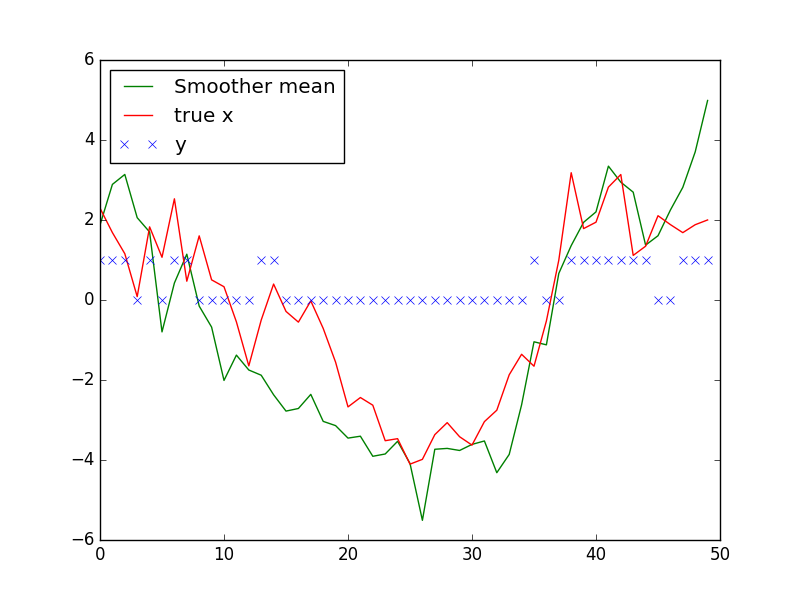

In [2]:
Image(filename='figure_1.png')

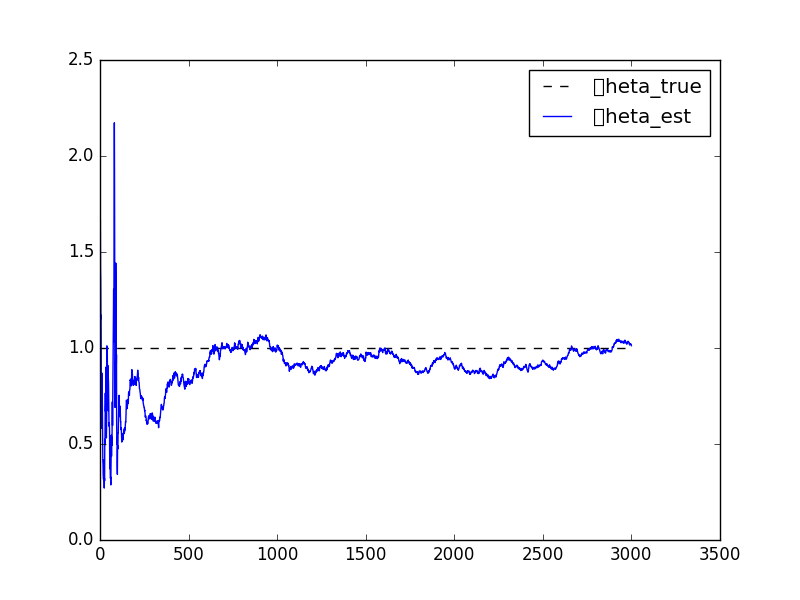

In [3]:
Image(filename='figure_2.png')

In [4]:
def likelihood(param,estimator,cur_iter):
    plt.figure(3)
    plt.clf()
    est_smooth = estimator.get_smoothed_estimates()
    diff=numpy.diff(est_smooth[:,:,0]-est_smooth[:,:,0],axis=0)
    logpx = kalman.lognormpdf_scalar(diff.ravel(), param)
    logpx0 = kalman.lognormpdf_scalar(est_smooth[0,:,0].ravel(), P0)
    lpx=numpy.sum(logpx) / backwardnum
    lpx0=numpy.sum(logpx0) / backwardnum

In [ ]:
param